In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read data to dataframe
df_train = pd.read_csv("train.csv",sep = ";")
df_test = pd.read_csv("test.csv", sep = ";")

df_train['subscribe'] = df_train['y'].apply(lambda x: '0' if x == 'no' else '1')
df_test['subscribe'] = df_test['y'].apply(lambda x: '0' if x == 'no' else '1')
df_train['subscribe'] = df_train['subscribe'].astype('int')
df_test['subscribe'] = df_test['subscribe'].astype('int')

# Part 2: Modeling

In [3]:
#import libraires
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


from sklearn.metrics import recall_score, fbeta_score, make_scorer, roc_auc_score, roc_curve
from sklearn.metrics import log_loss, confusion_matrix
from sklearn import metrics

In [4]:
#train-test-split for sample data  
X = df_train.drop(['y','subscribe', 'duration'], axis=1)
y = df_train['subscribe']

X_test = df_test.drop(['y','subscribe', 'duration'], axis=1)
y_test = df_test['subscribe']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state=101, stratify = y)

## Step 1: Finding a baseline model

### (1) Resampling - Oversampling

In [5]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1) #counting the positive case
n_neg = np.sum(y_train == 0) #counting the negative case
ratio = {1 : n_pos * 7, 0 : n_neg} 

# randomly oversample positive samples: create 7x as many   #RandomOverSampler
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train) #fit_resample

### (2) Try single numerial model first and compare (the features that can be a good classifier)
Note: "previous", "pdays" can be a good classifier if we just want a simple model

In [6]:
#use log loss to compare the model performance. 
X_tr_rs_num = X_tr_rs.loc[:,['age','balance','day','campaign', 'pdays', 'previous']]
X_val_num = X_val.loc[:,['age','balance','day','campaign', 'pdays', 'previous']]

my_columns = ['balance', 'campaign', 'previous','day', 'pdays']
for col in my_columns: #用一个for loop 将每一个variable 都分别fit in model
    X_tr = X_tr_rs_num[[col]]
    X_vl = X_val[[col]]
    logreg_model = LogisticRegression(C = 10000) #如果用default C=1， default penalty L2, then need to standardize before fit in model. 
    logreg_model.fit(X_tr,y_tr_rs)
    y_pred_vl = logreg_model.predict(X_vl)
    y_prob_pred_vl = logreg_model.predict_proba(X_vl)[:,1]
    
    print(col,f"log_loss: {log_loss(y_val,y_prob_pred_vl)}", f"f_beta: {fbeta_score(y_val, y_pred_vl,average='weighted',beta = 2)}", (f"ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_vl)}"))

balance log_loss: 0.6629575585854688 f_beta: 0.7958692767253508 ROC_AUC score: 0.5868955615029599
campaign log_loss: 0.6553108491364852 f_beta: 0.6334838396677306 ROC_AUC score: 0.5749267589395523
previous log_loss: 0.6512431138797472 f_beta: 0.8204357791508117 ROC_AUC score: 0.6062415587828313
day log_loss: 0.664091347159226 f_beta: 0.7040707763153647 ROC_AUC score: 0.5275752148700364
pdays log_loss: 0.656002696488991 f_beta: 0.7934418495220654 ROC_AUC score: 0.5971805003000665


### (3) Baseline model - Fit a logistic regression on all of the numerical variables only

In [7]:
#fit in with all numerical features - less loss than any single variable
logreg_model = LogisticRegression(C = 10000)
logreg_model.fit(X_tr_rs_num, y_tr_rs)  #all numerical only
y_pred_val = logreg_model.predict(X_val_num)
y_prob_pred_val = logreg_model.predict_proba(X_val_num)[:,1]

print(f"log_loss: {log_loss(y_val,y_prob_pred_val)}")
print(f"F-beta: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}")
print(f"ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_val)}")

print("\n")
print(confusion_matrix(y_val, y_pred_val))

print("\n")
print(X_train.columns)
print(logreg_model.coef_)

log_loss: 0.6403769377300643
F-beta: 0.7582782169110249
ROC_AUC score: 0.650254020712276


[[6290 1695]
 [ 589  469]]


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome'],
      dtype='object')
[[ 1.44406226e-03  4.95575905e-05 -4.06718128e-03 -1.19651500e-01
   1.30664778e-03  1.13136785e-01]]


ROC AUC validation score =  0.650254020712276


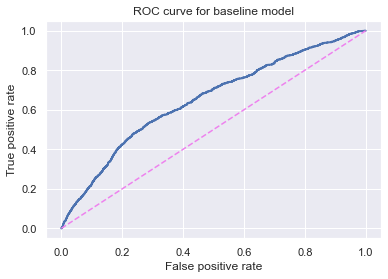

In [8]:
fpr, tpr, thresholds = roc_curve(y_val, logreg_model.predict_proba(X_val_num)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for baseline model');
print("ROC AUC validation score = ", roc_auc_score(y_val, logreg_model.predict_proba(X_val_num)[:,1]))

In [9]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_val_dum_predict = (model.predict_proba(X_val_num)[:, 1] >= threshold)
    subscription_confusion = confusion_matrix(y_val, y_pred_val)
    plt.figure(dpi=80)
    sns.heatmap(subscription_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no subscribe', 'yes subscribe'],
           yticklabels=['no subscribe', 'yes subscribe']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

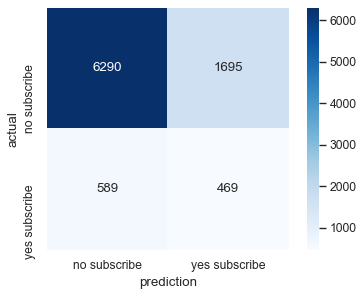

In [10]:
make_confusion_matrix(logreg_model, threshold=0.5)

## Step 2: training 6 candidate models

### Candidate Model 1: Logistic Regression (with scaled data)

In [11]:
X_dum = pd.get_dummies(X)
X_test_dum = pd.get_dummies(X_test)

#train_test_split
X_train_dum, X_val_dum, y_train, y_val = train_test_split(X_dum, y, test_size = 0.2, random_state=101)

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1) #counting the positive case
n_neg = np.sum(y_train == 0) #counting the negative case
ratio = {1 : n_pos * 7, 0 : n_neg} 

# randomly oversample positive samples: create 7x as many   #RandomOverSampler
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train_dum, y_train) #fit_resample

In [12]:
#scaling data and fit in model
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_tr_rs)
X_val_scaled = std_scale.transform(X_val_dum)
X_test_scaled = std_scale.transform(X_test_dum)

logreg1 = LogisticRegression(C=1)  # C affect our model dramatically
logreg1.fit(X_train_scaled, y_tr_rs)

y_pred_val = logreg1.predict(X_val_scaled)
y_prob_pred_val = logreg1.predict_proba(X_val_scaled)[:,1]

print(f"log_loss: {log_loss(y_val,y_prob_pred_val)}")

print(f"train f-beta score: {fbeta_score(y_tr_rs,logreg1.predict(X_train_scaled),average='weighted',beta = 2)}")
print(f"train ROC_AUC score: {roc_auc_score(y_tr_rs, logreg1.predict_proba(X_train_scaled)[:,1])}")
print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}")
print(f"val ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_val)}")


log_loss: 0.5305275968847742
train f-beta score: 0.7063390035353956
train ROC_AUC score: 0.772071510465866
val f-beta score: 0.7933164407170225
val ROC_AUC score: 0.7687979871841746


### Candidate Model 2 - KNN (Need Scale)

In [13]:
#using scaled data
# Train on training set, and Validate on validating set
knn = KNeighborsClassifier(n_neighbors=20)  #Need to assign n
knn.fit(X_train_scaled, y_tr_rs)  #fit
y_pred_val = knn.predict(X_val_scaled)  #predict
y_prob_pred_val = knn.predict_proba(X_val_scaled)[:,1]

print(f"train f-beta score: {fbeta_score(y_tr_rs,knn.predict(X_train_scaled),average='weighted',beta = 2)}")
print(f"train ROC_AUC score: {roc_auc_score(y_tr_rs, knn.predict_proba(X_train_scaled)[:,1])}")
print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}")
print(f"val ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_val)}")  

train f-beta score: 0.7909147838056466
train ROC_AUC score: 0.882551859671168
val f-beta score: 0.7632418971985185
val ROC_AUC score: 0.7392632755952266


### Candidate Model 3 - Random Forest

In [14]:
#Random Forest
RC = RandomForestClassifier(n_estimators=1000, max_features=6, max_depth = 10)
RC.fit(X_tr_rs, y_tr_rs)  
y_pred_val= RC.predict(X_val_dum)
y_prob_pred_val = RC.predict_proba(X_val_dum)[:,1]
print(f"train f-beta score: {fbeta_score(y_tr_rs,RC.predict(X_tr_rs),average='weighted',beta = 2)}")
print(f"train ROC_AUC score: {roc_auc_score(y_tr_rs,RC.predict(X_tr_rs))}")

print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}")
print(f"val ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_val)}")

train f-beta score: 0.7553884224270152
train ROC_AUC score: 0.7539231668328403
val f-beta score: 0.8347102855189789
val ROC_AUC score: 0.7923206989417275


### Candidate Model 4 - Grandient Boosted trees/XGBoost

In [15]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.5, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_tr_rs, y_tr_rs),(X_val_dum,y_val)]
fit_model = gbm.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

y_pred_val = gbm.predict(X_val_dum, ntree_limit=gbm.best_ntree_limit)
y_prob_pred_val = gbm.predict_proba(X_val_dum)[:,1]


print(f"train f-beta score: {fbeta_score(y_tr_rs,gbm.predict(X_tr_rs),average='weighted',beta = 2)}")
print(f"train ROC_AUC score: {roc_auc_score(y_tr_rs,gbm.predict(X_tr_rs))}")

print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}")
print(f"val ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_val)}")

train f-beta score: 0.7543852724476713
train ROC_AUC score: 0.7528029434743717
val f-beta score: 0.8329938154614569
val ROC_AUC score: 0.79925252472494


### Candidate Model 5 - Naive Bayes

In [16]:
clf = GaussianNB()
clf.fit(X_tr_rs, y_tr_rs)
y_pred_val = clf.predict(X_val_dum)
y_prob_pred_val = clf.predict_proba(X_val_dum)[:,1]

# print(gnb.theta_) 

print(f"train f-beta score: {fbeta_score(y_tr_rs,clf.predict(X_tr_rs),average='weighted',beta = 2)}")
print(f"train ROC_AUC score: {roc_auc_score(y_tr_rs,clf.predict(X_tr_rs))}")

print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}")
print(f"val ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_val)}")

train f-beta score: 0.6896389577740438
train ROC_AUC score: 0.6888896383055031
val f-beta score: 0.8016707936122375
val ROC_AUC score: 0.7487083148921431


### Candidate Model 6 - SVM(Need Scale)

In [17]:
svc=SVC()
svc.fit(X_train_scaled, y_tr_rs)
y_pred_val = svc.predict(X_val_scaled)

print(f"train f-beta score: {fbeta_score(y_tr_rs,svc.predict(X_train_scaled),average='weighted',beta = 2)}") 
print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}") 

train f-beta score: 0.7900124101780865
val f-beta score: 0.8388320101723521


In [18]:
svc=SVC(C = 30, gamma= 0.001)
svc.fit(X_train_scaled, y_tr_rs)
y_pred_val = svc.predict(X_val_scaled)

print(f"train f-beta score: {fbeta_score(y_tr_rs,svc.predict(X_train_scaled),average='weighted',beta = 2)}") 
print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}") 

train f-beta score: 0.7320037612668637
val f-beta score: 0.8533191421244004


## Step 3: Model Selection - Using ROC(soft predictions) & F-beta(hard predictions)
Note: XGBoost performs the best

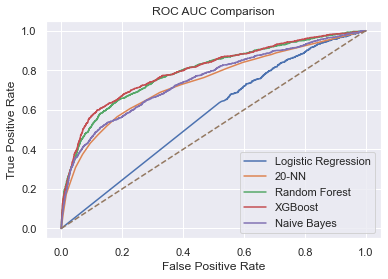

In [19]:
#use ROC curve compare different model. 
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_val, logreg1.predict_proba(X_val_dum)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_val, RC.predict_proba(X_val_dum)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_val, gbm.predict_proba(X_val_dum)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_val, clf.predict_proba(X_val_dum)[:,1])
plt.plot(fpr, tpr)

#fpr, tpr, _ = roc_curve(y_val_dum, svc.predict_proba(X_val_scaled)[:,1])
#plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC AUC Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression','20-NN','Random Forest','XGBoost','Naive Bayes'])
plt.savefig("ROC AUC Comparison.png");

## Step 4: tunning hyperparameter for XGBoost, then training final model

### Tunning hyperparameter

In [20]:
#baseline xgboost model:
  ## val f-beta score: 0.8329938154614569
  ## val ROC_AUC score: 0.79925252472494

# better hyperparameter 
gbm1 = xgb.XGBClassifier( 
                        n_estimators=10000,
                        max_depth=11,
                        objective='binary:logistic', #new objective
                        learning_rate=0.05, 
                        subsample=.8,
                        min_child_weight=2,
                        colsample_bytree=.8
                       )

eval_set=[(X_tr_rs, y_tr_rs),(X_val_dum,y_val)]
fit_model = gbm1.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                                    #can "eval_metric" be F-beta score
                    early_stopping_rounds=20,
                    verbose=False
                   )

y_pred_val = gbm1.predict(X_val_dum, ntree_limit=gbm1.best_ntree_limit)
y_prob_pred_val = gbm1.predict_proba(X_val_dum)[:,1]


print(f"train f-beta score: {fbeta_score(y_tr_rs,gbm.predict(X_tr_rs),average='weighted',beta = 2)}")
print(f"train ROC_AUC score: {roc_auc_score(y_tr_rs,gbm1.predict(X_tr_rs))}")

print(f"val f-beta score: {fbeta_score(y_val,y_pred_val,average='weighted',beta = 2)}")
print(f"val ROC_AUC score: {roc_auc_score(y_val, y_prob_pred_val)}")

train f-beta score: 0.7543852724476713
train ROC_AUC score: 0.8054520382097845
val f-beta score: 0.8536168453517327
val ROC_AUC score: 0.7983353332288714


### Final model - retrain XGBoost with (train+val) data, resampling, then get score on test set

In [21]:
X_dum = pd.get_dummies(X)
X_test_dum = pd.get_dummies(X_test)

# oversampling
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority', random_state=42) 
X_tr_rs, y_tr_rs = ROS.fit_resample(X_dum, y) #fit_resample

In [22]:
gbm2 = xgb.XGBClassifier( 
                        n_estimators=10000,
                        max_depth=11,
                        objective='binary:logistic', #new objective
                        learning_rate=0.05, 
                        subsample=.8, 
                        min_child_weight=2,
                        colsample_bytree=.8
                       )

eval_set=[(X_tr_rs, y_tr_rs),(X_test_dum,y_test)]  #using test set
fit_model = gbm2.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                                    #can "eval_metric" be F-beta score
                    early_stopping_rounds=20,
                    verbose=False
                   )

y_pred_test = gbm2.predict(X_test_dum, ntree_limit=gbm2.best_ntree_limit)
y_prob_pred_test = gbm2.predict_proba(X_test_dum)[:,1]


print(f"train f-beta score: {fbeta_score(y_tr_rs,gbm2.predict(X_tr_rs),average='weighted',beta = 2)}")
print(f"train ROC_AUC score: {roc_auc_score(y_tr_rs,gbm.predict(X_tr_rs))}")

print(f"test f-beta score: {fbeta_score(y_test,y_pred_test,average='weighted',beta = 2)}")
print(f"test ROC_AUC score: {roc_auc_score(y_test, y_prob_pred_test)}")

train f-beta score: 0.9967927081981969
train ROC_AUC score: 0.7477706527729072
test f-beta score: 0.9946969122222279
test ROC_AUC score: 0.9998795585412668


## Step 5: Model Interperatation

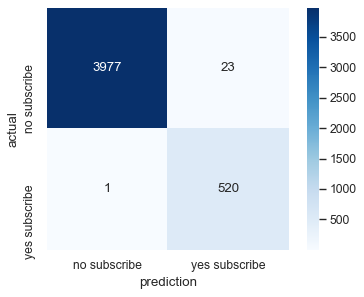

In [23]:
subscription_confusion = confusion_matrix(y_test, y_pred_test)
plt.figure(dpi=80)
sns.heatmap(subscription_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no subscribe', 'yes subscribe'],
           yticklabels=['no subscribe', 'yes subscribe']);
plt.xlabel('prediction')
plt.ylabel('actual');

ROC AUC validation score =  0.9998795585412668


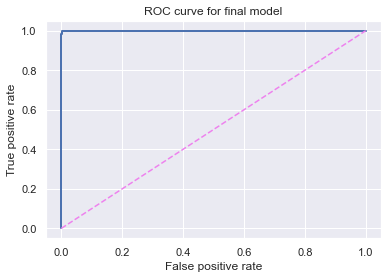

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, gbm2.predict_proba(X_test_dum)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for final model');
print("ROC AUC validation score = ", roc_auc_score(y_test, gbm2.predict_proba(X_test_dum)[:,1]))

In [ ]:
feat_imps = list(zip(X.columns,rf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')